# OpenVINO使ってMobileNetモデルを推論実行するデモ

これはOpenVINOによるディープラーニングモデルの推論デモです。OpenVINOを適用することで、インテルCPU上でモデルの推論性能が向上することを体験いただけます。
デモで使用するモデルは、こちらの[Notebook](Demo_Inference_MobileNet_with_OpenVINO.ipynb)で作成しておりまして、犬と猫の画像から計37種類のいずれの種類かを分類するCNNです。
<table border="0">
<tr>
<td><center>Abyssinian</center></td>
<td><center>American pit bull</center></td>
<td><center>Beagle</center></td>
<td><center>Bengal</center></td>
<td><center>Birman</center></td>
<td><center>Boxer</center></td>
<td><center>・・・</center></td>
</tr>
<tr>
<td><img src="./images/Abyssinian_9.jpg" width="112"></td>
<td><img src="./images/american_pit_bull_terrier_98.jpg" width="112"></td>
<td><img src="./images/beagle_82.jpg" width="112"></td>
<td><img src="./images/Bengal_121.jpg" width="112"></td>
<td><img src="./images/Birman_17.jpg" width="112"></td>
<td><img src="./images/boxer_54.jpg" width="112"></td>
<td><center>・・・</center><br/>(こういう感じで計37種類あります)</td>
</tr>
</table>
モデルは、MobileNetで、Keras（Tensorflow バックエンド）を用いて作成（学習）され、HDF5形式でExportされています。[こちら](top_layers.mn.hdf5)がそのモデルです。
ただし、OpenVINOのModel OptimizerはHDF5形式に対応していないため、モデルファイルをTensorflowのProtobuf形式（.pbファイル）に変換しています。それが[こちら](./tf_model/top_layers.mn.pb)です。

本デモでは、まずはHDF5形式のモデルをKerasを用いて複数の画像を対象に推論してみます。
続いて、同モデルをOpeVINOのIR形式に変換し、同様の画像を対象に推論し、推論性能がどの程度変化するか確認します。

## まずはオリジナルのモデル（Keras + Tensorflow）の推論用関数を定義

In [ ]:
from keras import models
model = models.load_model('top_layers.mn.hdf5') #モデルロードが時間かかるのでここでロード

In [ ]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
import numpy as np
import glob
import random
import time
import pandas as pd
import cv2
from PIL import Image
import PIL
import io
import IPython.display
from IPython.display import clear_output

def inference_original(cnnmodel, total = 100):
    model = cnnmodel
    
    #Read in Labels
    arg_labels="mn-labels.txt"
    label_file = open(arg_labels, "r")
    labels = label_file.read().split('\n')
    
    list_df = pd.DataFrame( columns=['正解ラベル','予測ラベル','全処理時間(msec)','推論時間(msec)'] )

    total_spent_time = 0
    total_infer_spent_time = 0
    
    for i in range(total):
        time1 = time.time()
        file_list = glob.glob("test/*/*")
        img_path = random.choice(file_list)
        img_cat = os.path.split(os.path.dirname(img_path))[1]
        # Read and pre-process input images
        n, c, h, w = 1, 3, 224, 224
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape[:-1] != (h, w):
            image = cv2.resize(image, (w, h))
        frame = image
        image = image.reshape((n, h, w, c))
        image = preprocess_input(image)

        time2 = time.time()
        preds = model.predict(image)
        
        infer_spent_time = time.time() - time2
        total_infer_spent_time += infer_spent_time
        
        spent_time = time.time() - time1
        total_spent_time += spent_time
        
        top = preds[0].argsort()[-1:][::-1]
        pred_label = labels[top[0]]
        clear_output(wait=True)
        cv2.putText(frame,str(i) + ':', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame,str(i) + ':', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(frame,str(img_cat), (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame,str(img_cat), (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(frame,str(pred_label), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame,str(pred_label), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        f = io.BytesIO()
        PIL.Image.fromarray(frame).save(f, 'jpeg')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))
        tmp_se = pd.Series( [img_cat, pred_label, str(int(spent_time * 1000)), str(int(infer_spent_time * 1000)) ], index=list_df.columns )
        list_df = list_df.append( tmp_se, ignore_index=True )
        
    clear_output(wait=True)
    print()
    print('全' + str(total) + '枚 完了！')
    print()
    print("平均処理時間: " + str(int((total_spent_time / total)*1000.0)) + " ms/枚")
    print("平均推論時間: " + str(int((total_infer_spent_time / total)*1000.0)) + " ms/枚")
    display(list_df)
    
    return int((total_spent_time / total)*1000.0), int((total_infer_spent_time / total)*1000.0)

## 続いて、オリジナルのモデルをOpenVINOのIR形式に変換

OpenVINOに付属しているModel Optimizerを用います。
大前提として、OSの環境変数に下記がセットされている必要があります。

PYTHONPATH=c:\Program Files (x86)\IntelSWTools\openvino\python\python3.6;c:\Program Files (x86)\IntelSWTools\openvino\python\python3;

より詳しい説明は下記URLをご覧ください。 https://docs.openvinotoolkit.org/latest/_docs_MO_DG_prepare_model_convert_model_Converting_Model.html

In [ ]:
!python "c:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\model_optimizer\mo.py" --input_model=tf_model\top_layers.mn.pb --input_shape=[1,224,224,3]

モデルが正常に変換されると、xmlファイルとbinファイルが出来上がります。これがOpenVINOで用いられるIR形式のモデルの実体です。

## ここで、IR形式のモデルを推論処理するための関数を定義

In [ ]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras import models
import numpy as np
import glob
import random
import time
import os
import cv2
import pandas as pd
from PIL import Image
import PIL
import io
import IPython.display
from IPython.display import clear_output

from openvino.inference_engine import IENetwork, IEPlugin

def inference_openvino(total = 100, target_device="CPU"):
    model_xml = 'top_layers.mn.xml'
    model_bin = 'top_layers.mn.bin'

    # Plugin initialization for specified device and load extensions library if specified
    ie = IEPlugin(device=target_device, plugin_dirs='')

    # Read IR
    net = IENetwork(model=model_xml, weights=model_bin)

    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    net.batch_size = 1

    # Loading model to the plugin
    exec_net = ie.load(network=net)
    
    #Read in Labels
    arg_labels="mn-labels.txt"
    label_file = open(arg_labels, "r")
    labels = label_file.read().split('\n')
    
    list_df = pd.DataFrame( columns=['正解ラベル','予測ラベル','全処理時間(msec)','推論時間(msec)'] )

    total_spent_time = 0
    total_infer_spent_time = 0
    
    for j in range(total):
        time1 = time.time()
        file_list = glob.glob("test/*/*")
        img_path = random.choice(file_list)
        img_cat = os.path.split(os.path.dirname(img_path))[1]
        # Read and pre-process input images
        n, c, h, w = net.inputs[input_blob].shape
        images = np.ndarray(shape=(n, c, h, w))
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape[:-1] != (h, w):
            image = cv2.resize(image, (w, h))
        frame = image
        image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
        image = image.reshape((n, c, h, w))
        image = preprocess_input(image)
        images[0] = image

        # Start sync inference
        time2 = time.time()
        preds = exec_net.infer(inputs={input_blob: images})
        
        infer_spent_time = time.time() - time2
        total_infer_spent_time += infer_spent_time
        
        spent_time = time.time() - time1
        total_spent_time += spent_time
        
        preds = preds[out_blob]
        top = preds[0].argsort()[-1:][::-1]
        pred_label = labels[top[0]]
        clear_output(wait=True)
        cv2.putText(frame,str(j) + ':', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame,str(j) + ':', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(frame,str(img_cat), (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame,str(img_cat), (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(frame,str(pred_label), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(frame,str(pred_label), (10,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        f = io.BytesIO()
        PIL.Image.fromarray(frame).save(f, 'jpeg')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))
        #print(str(j + 1) + '枚目: 正解=' + img_cat + '、予測=' + pred_label + '、全処理時間=' + str(int(spent_time * 1000)) + 'msec、推論時間=' + str(int(infer_spent_time * 1000)) + ' msec')
        tmp_se = pd.Series( [img_cat, pred_label, str(int(spent_time * 1000)), str(int(infer_spent_time * 1000)) ], index=list_df.columns )
        list_df = list_df.append( tmp_se, ignore_index=True ) 

    clear_output(wait=True)
    print()
    print('全' + str(total) + '枚 完了！')
    print()
    print("平均処理時間: " + str(int((total_spent_time / total)*1000.0)) + " ms/枚")
    print("平均推論時間: " + str(int((total_infer_spent_time / total)*1000.0)) + " ms/枚")
    display(list_df)
    
    return int((total_spent_time / total)*1000.0), int((total_infer_spent_time / total)*1000.0)

## では、2つの関数を実行して性能を比較しましょう

## まずは、オリジナルのモデルから実行

In [57]:
original_total_time, original_infer_time = inference_original(model, total=50)


全50枚 完了！

平均処理時間: 235 ms/枚
平均推論時間: 185 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,scottish_terrier,scottish_terrier,233,186
1,havanese,havanese,227,188
2,birman,birman,223,184
3,samoyed,samoyed,237,189
4,staffordshire_bull_terrier,american_pit_bull_terrier,233,182
5,great_pyrenees,great_pyrenees,259,200
6,persian,persian,223,176
7,russian_blue,russian_blue,222,182
8,sphynx,sphynx,216,173
9,keeshond,keeshond,229,184


## 続いて、OpenVINOのIR形式のモデルを実行

In [58]:
cpu_total_time, cpu_infer_time = inference_openvino(total=50, target_device="CPU")


全50枚 完了！

平均処理時間: 66 ms/枚
平均推論時間: 11 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,russian_blue,russian_blue,61,13
1,scottish_terrier,scottish_terrier,47,10
2,egyptian_mau,egyptian_mau,65,10
3,maine_coon,maine_coon,72,15
4,great_pyrenees,great_pyrenees,55,10
5,samoyed,samoyed,63,11
6,birman,siamese,62,10
7,sphynx,abyssinian,53,9
8,egyptian_mau,egyptian_mau,65,11
9,sphynx,sphynx,62,9


## 同じIR形式のモデルを内臓GPUに推論処理をオフロードして実行

In [59]:
gpu_total_time, gpu_infer_time = inference_openvino(total=50, target_device="GPU")


全50枚 完了！

平均処理時間: 59 ms/枚
平均推論時間: 7 ms/枚


,正解ラベル,予測ラベル,全処理時間(msec),推論時間(msec)
0,beagle,beagle,70,16
1,bombay,bombay,50,7
2,english_setter,english_setter,56,7
3,american_pit_bull_terrier,american_pit_bull_terrier,69,7
4,egyptian_mau,maine_coon,47,7
5,pug,pug,44,7
6,british_shorthair,russian_blue,60,7
7,samoyed,samoyed,61,6
8,saint_bernard,saint_bernard,65,8
9,newfoundland,newfoundland,60,8


## 結果をグラフ化して比較してみましょう

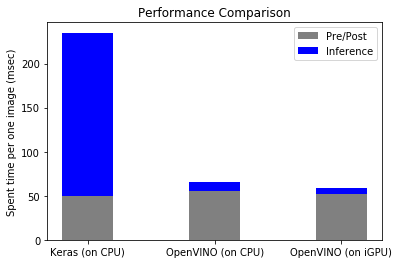

In [67]:
import matplotlib.pyplot as plt
import numpy as np

w = 0.4

Y1 = [original_total_time - original_infer_time, cpu_total_time - cpu_infer_time, gpu_total_time - gpu_infer_time]
Y2 = [original_infer_time, cpu_infer_time, gpu_infer_time]

X = np.arange(len(Y1))

plt.bar(X, Y1, color='gray', width=w, label='Pre/Post', align="center")
plt.bar(X, Y2, color='blue', width=w, bottom=Y1, label='Inference', align="center")

plt.legend(loc="best")
plt.title('Performance Comparison')
plt.ylabel("Spent time per one image (msec)")

plt.xticks(X, ['Keras (on CPU)','OpenVINO (on CPU)','OpenVINO (on iGPU)'])

plt.show()

## いかがでしたでしょうか？
## これより下は、この2つのモデルを用いた動画データに対する推論性能の比較デモです。

# OpenVINO Video Inference on CPU

Copyright (c) 2019 Intel Corporation.

Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Objective 
Transform your frozen graph into an intermediate representation (.bin/.xml) needed to use with OpenVINO then instantiate your OpenVINO model and inference live on a video file.

# Activities 
**In this section of the training you will**
- Understand OpenVINO Arguments
- Instantiate OpenVINO Network
- Use OpenCV to read video and pass frames to OpenVINO

Click the cell below and then click **Run**.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import PIL
import io
import IPython.display
from IPython.display import clear_output

### Instantiate Network

Next, we'll instantiate our network.  If you want to take a closer look at all the specific steps required to instantitate the network look at the inference.py file included in this directory.  Instead, we're going to look at the parameters passed to the constructor.  We see the .XML file passed as the base model, no CPU extensions and targeting the CPU as the device type.

Then we'll call out to the constructor for the Network instantiation. We then want to load our model into that network by passing in the above parameters to load_model. Lastly, we'll read in our labels file that we're going to use to decode the results during our inference.

Click the cell below and then click **Run**.

In [ ]:
from inference import Network
import sys

arg_model="top_layers.mn.xml"
arg_cpu_extension=None
arg_device="GPU"

# Initialise the class
infer_network = Network()
# Load the network to IE plugin to get shape of input layer
plugin, (n_fd, c_fd, h_fd, w_fd) = infer_network.load_model(arg_model, arg_device, 1, 1, 0, arg_cpu_extension)

#Read in Labels
arg_labels="mn-labels.txt"
label_file = open(arg_labels, "r")
labels = label_file.read().split('\n')

Now for the inference!  There are 8 steps that we're doing in the code below:
- Start a video or webcam capture
- Read the video frame
- Put the classification text on to the frame
- Render the frame to the Cell output field
- Resize/Transpose/Reshape/Preprocess frame
- Start an inference request
- Interpret the inference result
- Clear frame from notebook cell

Click the cell below and then click **Run**.

In [ ]:
from keras.applications.mobilenet import preprocess_input
import time

cap = cv2.VideoCapture("persian.mp4")
pred_label = ""
fps = 0
ips = 0
while True:
    time1 = time.time()
    ret, next_frame = cap.read()
    
    if ret:
        next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB)

        cv2.putText(next_frame,str(pred_label) + " " + str(fps) + "fps " + str(ips) + "ips", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(next_frame,str(pred_label) + " " + str(fps) + "fps " + str(ips) + "ips", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

        f = io.BytesIO()
        PIL.Image.fromarray(next_frame).save(f, 'jpeg')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))

        in_frame_fd = cv2.resize(next_frame, (w_fd, h_fd))
        in_frame_fd = in_frame_fd.transpose((2, 0, 1))
        in_frame_fd = in_frame_fd.reshape((n_fd, c_fd, h_fd, w_fd))
        in_frame_fd = preprocess_input(in_frame_fd)

        time3 = time.time()
        # Start asynchronous inference for specified request
        infer_network.exec_net(0, in_frame_fd)
        # Wait for the result
        infer_network.wait(0)
        # Results of the output layer of the network
        res = infer_network.get_output(0)
        time4 = time.time()

        top = res[0].argsort()[-1:][::-1]
        pred_label = labels[top[0]]

        time2 = time.time()
        fps = '%.1f' % (1/(time2-time1))
        ips = '%.1f' % (1/(time4-time3))

        clear_output(wait=True)
    else:
        break

clear_output(wait=True)
print("Video Ended")
infer_network.clean()
cap.release()
cv2.destroyAllWindows()

Below is the case that Original model is used for the same video data. You probably can see the difference of performance.

In [ ]:
from keras.applications.mobilenet import preprocess_input
import time
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras import models
import numpy as np
import glob
import random

model = models.load_model('top_layers.mn.hdf5')

cap = cv2.VideoCapture("persian.mp4")
pred_label = ""
fps = 0
ips = 0
while True:
    time1 = time.time()
    ret, next_frame = cap.read()
    
    if ret:
        next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB)

        cv2.putText(next_frame,str(pred_label) + " " + str(fps) + "fps " + str(ips) + "ips", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,2550), 4)
        cv2.putText(next_frame,str(pred_label) + " " + str(fps) + "fps " + str(ips) + "ips", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

        f = io.BytesIO()
        PIL.Image.fromarray(next_frame).save(f, 'jpeg')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))

        in_frame_fd = cv2.resize(next_frame, (w_fd, h_fd))
        #in_frame_fd = in_frame_fd.transpose((2, 0, 1))
        in_frame_fd = in_frame_fd.reshape((n_fd, h_fd, w_fd, c_fd))
        in_frame_fd = preprocess_input(in_frame_fd)

        time3 = time.time()
        # Start inference for specified request
        res = model.predict(in_frame_fd)
        time4 = time.time()

        top = res[0].argsort()[-1:][::-1]
        pred_label = labels[top[0]]

        time2 = time.time()
        fps = '%.1f' % (1/(time2-time1))
        ips = '%.1f' % (1/(time4-time3))

        clear_output(wait=True)
    else:
        break

clear_output(wait=True)
print("Video Ended")
cap.release()
cv2.destroyAllWindows()

## Summary
 
**In this section of the training you learned**
- Create Intermediate Representation (.bin/.xml)
- Understand OpenVINO Arguments
- Instantiate OpenVINO Network
- Use OpenCV to read video and pass frames to OpenVINO